<a href="https://colab.research.google.com/github/mohityadav11a/asteroid_spectra/blob/main/7_multiclass_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7. ML - Multi-Class Support Vector Machine

In [3]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [4]:
# Mount the Google Drive
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

Mounted at /gdrive


In [5]:
# Loading level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [6]:
# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [7]:
# creating single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Creating single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]

# Computing class weightnings
weight_dict = {}
for ast_type in np.unique(y_train):
    weight_dict[ast_type] = int(1.0 / (len(y_train[y_train == ast_type]) / (len(y_train))))

In [14]:
from sklearn.metrics import make_scorer, f1_score
import warnings
warnings.filterwarnings("ignore")
# Performing GridSearch with the following parameter range and kernels
param_grid = [
  {'C': np.logspace(0, 3.5, 25), 'kernel': ['rbf']}
 ]

# Set the SVM classifier
svc = svm.SVC(class_weight=weight_dict)

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Set the GridSearch. Using the f1 "weighted" score in a maker_scorer function.
wclf = GridSearchCV(svc, param_grid, scoring=make_scorer(f1_score, average="weighted"), verbose=3, cv=5)

# perform the training
wclf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ...................C=1.0, kernel=rbf;, score=nan total time=   0.0s
[CV 2/5] END ...................C=1.0, kernel=rbf;, score=nan total time=   0.0s
[CV 3/5] END ...................C=1.0, kernel=rbf;, score=nan total time=   0.0s
[CV 4/5] END ...................C=1.0, kernel=rbf;, score=nan total time=   0.0s
[CV 5/5] END ...................C=1.0, kernel=rbf;, score=nan total time=   0.0s
[CV 1/5] END ....C=1.3990503141372939, kernel=rbf;, score=nan total time=   0.0s
[CV 2/5] END ....C=1.3990503141372939, kernel=rbf;, score=nan total time=   0.0s
[CV 3/5] END ....C=1.3990503141372939, kernel=rbf;, score=nan total time=   0.0s
[CV 4/5] END ....C=1.3990503141372939, kernel=rbf;, score=nan total time=   0.0s
[CV 5/5] END ....C=1.3990503141372939, kernel=rbf;, score=nan total time=   0.0s
[CV 1/5] END ....C=1.9573417814876604, kernel=rbf;, score=nan total time=   0.0s
[CV 2/5] END ....C=1.9573417814876604, kernel=r

GridSearchCV(cv=5,
             estimator=SVC(class_weight={np.str_('C'): 3, np.str_('Other'): 8,
                                         np.str_('S'): 2, np.str_('X'): 5}),
             param_grid=[{'C': array([1.00000000e+00, 1.39905031e+00, 1.95734178e+00, 2.73841963e+00,
       3.83118685e+00, 5.36002317e+00, 7.49894209e+00, 1.04913973e+01,
       1.46779927e+01, 2.05352503e+01, 2.87298483e+01, 4.01945033e+01,
       5.62341325e+01, 7.86743808e+01, 1.10069417e+02, 1.53992653e+02,
       2.15443469e+02, 3.01416253e+02, 4.21696503e+02, 5.89974626e+02,
       8.25404185e+02, 1.15478198e+03, 1.61559810e+03, 2.26030303e+03,
       3.16227766e+03]),
                          'kernel': ['rbf']}],
             scoring=make_scorer(f1_score, response_method='predict', average=weighted),
             verbose=3)

In [9]:
# SVM results
final_clf = wclf.best_estimator_

print(f"Kernel with the best result: {final_clf.kernel}")
print(f"SVM information: {final_clf}")

Kernel with the best result: rbf
SVM information: SVC(C=np.float64(1.0),
    class_weight={np.str_('C'): 3, np.str_('Other'): 8, np.str_('S'): 2,
                  np.str_('X'): 5})


In [15]:
# Scaling testing data
X_test_scaled = scaler.transform(X_test)

# predicition
y_test_pred = final_clf.predict(X_test_scaled)

In [16]:
# Importing confusion matrix and performing the computation
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_test_pred, labels=["C", "S", "X", "Other"])

print(conf_mat)

[[ 77   0   2   0]
 [  0 106   0   4]
 [  2   0  46   0]
 [  0   1   0  30]]


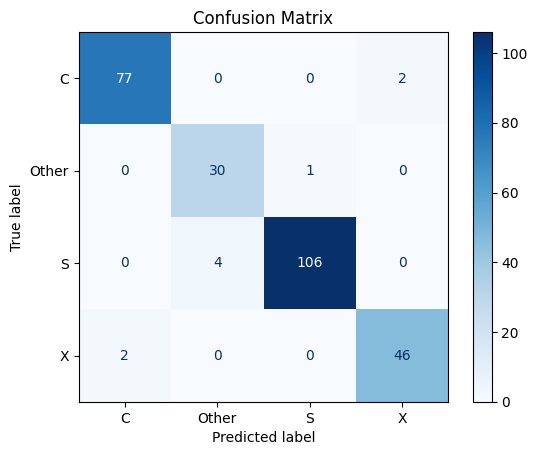

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(
    final_clf,             # Your trained classifier
    X_test_scaled,         # Test features
    y_test,                # True labels
    display_labels=final_clf.classes_ if hasattr(final_clf, "classes_") else None,
    cmap=plt.cm.Blues,     # Color map
    values_format='d'      # Format integers
)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [13]:
# A combined score
f1_score = round(sklearn.metrics.f1_score(y_test, y_test_pred, average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.967
